# Part 1 ‐ Exploratory data analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
logins = pd.read_json("data/logins.json")

In [4]:
from copy import deepcopy

logins_count = deepcopy(logins)
logins_count["count"] = 1
logins_count = logins_count.set_index("login_time")
logins_count_15min = logins_count.groupby(pd.Grouper(freq="15Min")).sum()
logins_count_15min.index.name = "DateTime"

Text(0.5, 1.0, 'Login rate by day')

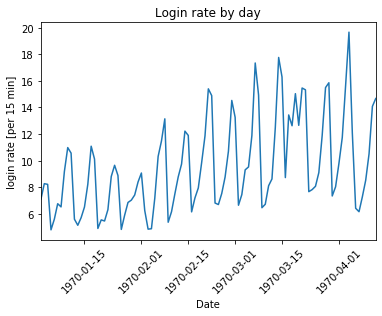

In [5]:
logins_count_byday = logins_count_15min.groupby(logins_count_15min.index.date).mean()
logins_count_byday = logins_count_byday[1 : -1]
logins_count_byday.index.name = "Date"

logins_count_byday.plot(y="count", rot=45, legend=None)
plt.ylabel("login rate [per 15 min]")
plt.title("Login rate by day")

The average login rate by day shows a weekly pattern.

Text(0.5, 1.0, 'Login rate by day of week')

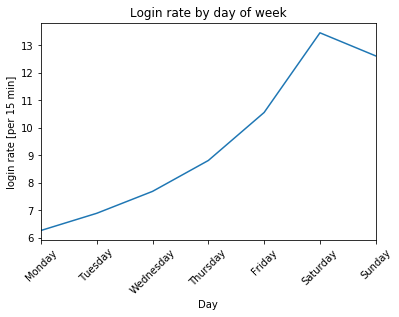

In [6]:
logins_count_week = logins_count_15min["1970-01-02" : "1970-04-12"].groupby(logins_count_15min["1970-01-02" : "1970-04-12"].index.weekday).mean()
logins_count_week.index.name = "Day"

logins_count_week.plot(y="count", rot=45, legend=None)
plt.xticks(ticks=range(7), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.ylabel("login rate [per 15 min]")
plt.title("Login rate by day of week")

The login rate increases from Monday to Friday, and reaches a peak in the weekend.

Text(0.5, 1.0, 'Login rate by week')

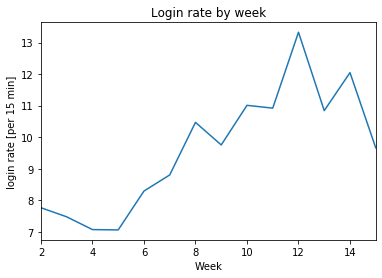

In [7]:
logins_count_byweek = logins_count_15min.groupby(logins_count_15min.index.week).mean()
logins_count_byweek = logins_count_byweek[1 : -1]
logins_count_byweek.index.name = "Week"

logins_count_byweek.plot(y="count", legend=None)
plt.ylabel("login rate [per 15 min]")
plt.title("Login rate by week")

The weekly login rate slowly increases that year and reaches a peak in the 12th week.

Text(0.5, 1.0, 'Login rate by hour')

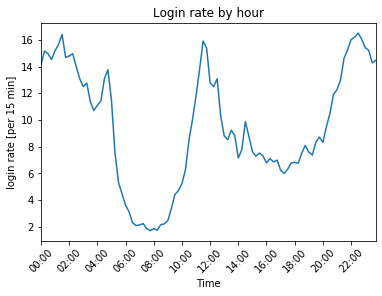

In [8]:
from matplotlib.dates import HourLocator

logins_count_average_day = logins_count_15min.groupby(logins_count_15min.index.time).mean()
logins_count_average_day.index.name = "Time"

logins_count_average_day.plot(y="count",rot=45, legend=None)
plt.xticks([7200 * h for h in range(12)])
plt.ylabel("login rate [per 15 min]")
plt.title("Login rate by hour")

On average, There are 2 peak hours in a day, 11:00 - 13:00 and 22:00 - 05:00.

Text(0.5, 1.0, 'Hourly login rate on different days of week')

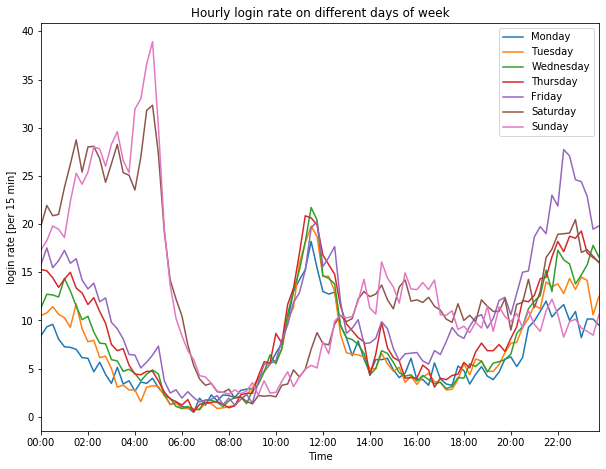

In [9]:
logins_count_average_dayofweek_time = logins_count_15min.groupby([logins_count_15min.index.weekday, logins_count_15min.index.time]).mean()

day_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.figure(figsize=(10, 7.5))
for i in range(7):
    plt.plot(logins_count_average_dayofweek_time.loc[i], label=day_of_week[i])
plt.ylabel("login rate [per 15 min]")
plt.xticks([7200 * h for h in range(12)])
plt.xlabel("Time")
plt.legend(loc="upper right")
plt.xlim([0, 3600 * 23.75])
plt.title("Hourly login rate on different days of week")

The login rate has different hourly patterns on the weekends and weekdays. On the weekdays, the peak is usually around noon. On the weekends, most logins happen after midnight.

Text(0, 0.5, 'login rate [per 15 min]')

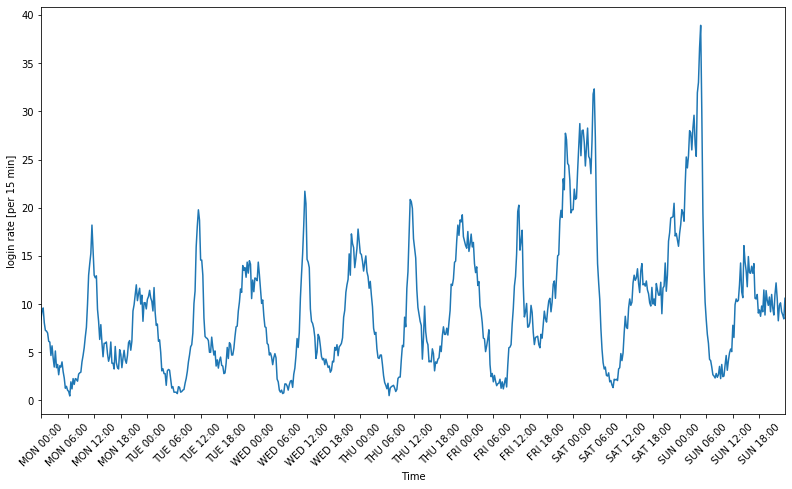

In [10]:
from itertools import product

timeIndex = [i * 15 for i in range(len(logins_count_average_dayofweek_time))]

plt.figure(figsize=(40/3, 7.5))
plt.plot(timeIndex, logins_count_average_dayofweek_time["count"])
day_of_week = ["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"]
xlabels = list(map(lambda x: x[0] + " " + x[1], product(day_of_week, ["00:00", "06:00", "12:00", "18:00"])))
plt.xlabel("Time")
plt.xticks([i * 6 * 60 for i in range(4 * 7)], xlabels, rotation=45)
plt.xlim([0, 60 * (24 * 6 + 23.75)])
plt.ylabel("login rate [per 15 min]")

# Part 2 - Experiment and metrics design

The goal of this experiment is to increase the availability of drivers in both cities by encouraging them to cross the bridge. The crucial metrics that are related to driver availability is the wait time passengers experience after they request a ride and before a driver comes for pick-up. Higher driver availibity should significantly diminish the average wait time.

A practical experiment should be conducted during two weeks when there are no holidays. For the whole second week, the drivers should be reimbursed for toll fees when they cross the bridge. The first week's data can be used as control.

The trips passengers take should be binned in 15 or 30-min time windows, and the data scientist may use a two-independent-sample t-tset (the exact test to use whould be decided finally given the collected data and its distribution) to compare whether the average wait time in either city during corresponding time windows differes between the two weeks.

One reasonable expectation of outcome of the experiment is that at certain time windows of a day in the week, the wait time is significantly shortenned, and at other time windows, it is not. This means that reimbursing toll fees ahould be able to increase driver availability in one city or another or in both. For instance, availability may improve in the peak hour of one city by the experiment, while at other times, it does not.

Given the result, the company might be able to launch hour-specific toll-reimbursement strategies to improve driver availabilities when the hour is right. On the other hand, cost-effectiveness analysis is also needed to asses the benefit/profit that lauching a toll-reimbursement plan brings by comparing it to the increasing cost introduced by this plan.

# Part 3 ‐ Predictive modeling

## Cleaning and visualization

In [11]:
import json

with open("data/ultimate_data_challenge.json") as file:
    users = pd.DataFrame(json.load(file))
    
users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [12]:
users.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [14]:
users.avg_rating_of_driver[users.avg_rating_of_driver.isnull()] = users.avg_rating_of_driver.mean()
users.avg_rating_by_driver[users.avg_rating_by_driver.isnull()] = users.avg_rating_by_driver.mean()

In [15]:
users.phone[users.phone.isnull()] = "other"

There are missing data in the ```avg_rating_of_driver```, ```avg_rating_by_driver``` and ```phone``` columns. The missing ratings are populated with the corresponding means, and the missing phones are named "other".

Text(0.5, 1.0, 'post-sign-up day -- retention rate')

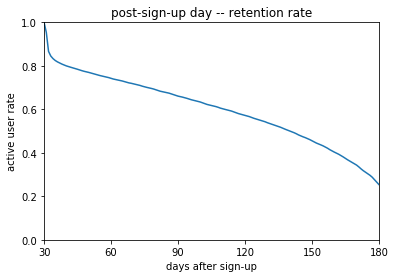

In [16]:
from datetime import timedelta

users.signup_date = pd.to_datetime(users.signup_date)
users.last_trip_date = pd.to_datetime(users.last_trip_date)

active_days = users.last_trip_date - users.signup_date

active_rate = [(active_days >= timedelta(d - 30)).mean() for d in range(181)]
plt.plot(range(181), active_rate)
plt.xlim([30, 180])
plt.xticks([30 * d for d in range(1, 7)])
plt.xlabel("days after sign-up")
plt.ylim([0, 1])
plt.ylabel("active user rate")
plt.title("post-sign-up day -- retention rate")

About 80% of users keep using the service after the first month. Half a year after sign-up, about 30% users are retained.

In [17]:
from datetime import date

cutoff_date = date(year=2014, month=6, day=1)
active = users.last_trip_date > cutoff_date
active.name = "active"

Users whose last trip is after 06/01/2014 are identified as active/retained useres.

In [18]:
pd.crosstab(users.city, active, normalize="index")

active,False,True
city,,
Astapor,0.756744,0.243256
King's Landing,0.377394,0.622606
Winterfell,0.657996,0.342004


More users in King's Landing are active than those in Astapor and Winterfell.

In [19]:
pd.crosstab(users.phone, active, normalize="index")

active,False,True
phone,,
Android,0.804154,0.195846
iPhone,0.559366,0.440634
other,0.671717,0.328283


About 80% Android users are no longer active.

In [20]:
pd.crosstab(users.ultimate_black_user, active, normalize="index")

active,False,True
ultimate_black_user,,
False,0.712612,0.287388
True,0.503607,0.496393


Non-ultimate black users are less likely to stay active.

In [21]:
pd.pivot_table(pd.concat([users[["trips_in_first_30_days", "avg_rating_of_driver", "avg_surge", "surge_pct", "weekday_pct", "avg_dist", "avg_rating_by_driver"]], active], axis=1), index="active")

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
active,,,,,,,
False,6.188478,4.786830,4.605889,1.075367,8.688548,1.659167,60.181597
True,5.118977,4.763149,4.594066,1.073720,9.128165,3.349590,62.214604


Active users tend to travel shorter distance than inactive users. They travel slightly more frequentyly on weekdays than inactive users. They also take slightly more surge trips. Active users usually take more trips than inactive users within the first 30 days of their sign-up.

The difference between the ratings either received or given by active an inactive users is very minimal. There is also no significant difference in average surge rate. Thus, these columns are ignored in the predictive model.

Text(0.5, 1.0, 'Histogram -- average distance')

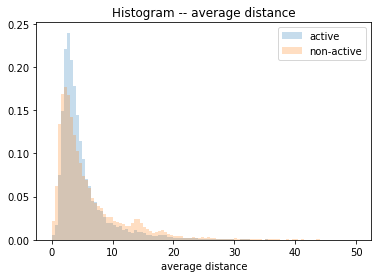

In [22]:
plt.hist(users.avg_dist[active], bins=np.linspace(0, 50, 101), density=True, alpha=0.25, label="active")
plt.hist(users.avg_dist[~active], bins=np.linspace(0, 50, 101), density=True, alpha=0.25, label="non-active")
plt.legend()
plt.xlabel("average distance")
plt.title("Histogram -- average distance")

Text(0.5, 1.0, 'Histogram -- log-10 of average distance')

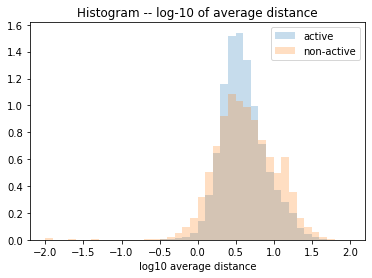

In [23]:
log_avg_dist = np.log10(users.avg_dist)
plt.hist(log_avg_dist[active], bins=np.linspace(-2, 2, 41), density=True, alpha=0.25, label="active")
plt.hist(log_avg_dist[~active], bins=np.linspace(-2, 2, 41), density=True, alpha=0.25, label="non-active")
plt.legend()
plt.xlabel("log10 average distance")
plt.title("Histogram -- log-10 of average distance")

```avg_dist``` is log normal. Thus, it should be transformed to log scale.

Text(0.5, 1.0, 'Histogram of number of trips taken within first 30 days of sign-up')

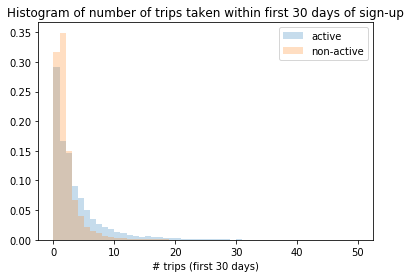

In [24]:
plt.hist(users.trips_in_first_30_days[active], bins=np.linspace(0, 50, 51), density=True, alpha=0.25, label="active")
plt.hist(users.trips_in_first_30_days[~active], bins=np.linspace(0, 50, 51), density=True, alpha=0.25, label="non-active")
plt.legend()
plt.xlabel("# trips (first 30 days)")
plt.title("Histogram of number of trips taken within first 30 days of sign-up")

```trips_in_first_30_days``` is Poisson distributed. However, as the variance in the data is not extreme, stablization transforms may not be necessary.

In [25]:
users_processed = users[["trips_in_first_30_days", "surge_pct", "weekday_pct", "avg_dist"]]
users_processed.surge_pct = users_processed.surge_pct / 100
users_processed.weekday_pct = users_processed.weekday_pct / 100
users_processed.avg_dist[users_processed.avg_dist == 0] = 0.01
users_processed.avg_dist =np.log10(users_processed.avg_dist)

The ```avg_dist``` is converted to log-10 scale.

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

label_encoder_city = LabelEncoder()
integer_city = label_encoder_city.fit_transform(users.city)
onehot_encoder_city = OneHotEncoder(sparse=False)
onehot_city = onehot_encoder_city.fit_transform(integer_city.reshape(-1, 1))
city = pd.DataFrame(onehot_city[:, [0, 1]], columns=["city_0", "city_1"], index = users_processed.index)

In [27]:
label_encoder_phone = LabelEncoder()
integer_phone = label_encoder_city.fit_transform(users.phone)
onehot_encoder_phone = OneHotEncoder(sparse=False)
onehot_phone = onehot_encoder_phone.fit_transform(integer_phone.reshape(-1, 1))
phone = pd.DataFrame(onehot_phone[:, [0, 1]], columns=["phone_0", "phone_1"], index = users_processed.index)

In [28]:
label_encoder_black = LabelEncoder()
integer_black = label_encoder_black.fit_transform(users.ultimate_black_user)
ultimate_black_user = pd.DataFrame(integer_black, columns = ["ultimate_black_user"], index = users_processed.index)

The ```city```, ```phone``` and ```ultimate_black_user``` columns are converted to one hot encoding.

In [29]:
users_processed = pd.concat([users_processed, city, phone, ultimate_black_user], axis=1)

In [30]:
users_processed.head()

,trips_in_first_30_days,surge_pct,weekday_pct,avg_dist,city_0,city_1,phone_0,phone_1,ultimate_black_user
0,4,0.154,0.462,0.564666,0.0,1.0,0.0,1.0,1
1,0,0.000,0.500,0.916980,1.0,0.0,1.0,0.0,0
2,3,0.000,1.000,-0.113509,1.0,0.0,0.0,1.0,0
3,9,0.200,0.800,0.372912,0.0,1.0,0.0,1.0,1
4,14,0.118,0.824,0.495544,0.0,0.0,1.0,0.0,0


The pre-processed data ready for the model contain ```trip_in_first_30_days```, ```surge_pct```, ```weekday_pct```, ```avg_dist```, ```city```, ```phone``` and ```ultimate_black_user```. 

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(users_processed, active, test_size=0.2)

train_avg_dist_maen = X_train.avg_dist.mean()
train_avg_dist_sd = X_train.avg_dist.std()
X_train.avg_dist = (X_train.avg_dist - train_avg_dist_maen) / train_avg_dist_sd
X_test.avg_dist = (X_test.avg_dist - train_avg_dist_maen) / train_avg_dist_sd

train_trips_30_mean = X_train.trips_in_first_30_days.mean()
train_trips_30_sd = X_train.trips_in_first_30_days.std()
X_train.trips_in_first_30_days = (X_train.trips_in_first_30_days - train_trips_30_mean) / train_trips_30_sd
X_test.trips_in_first_30_days = (X_test.trips_in_first_30_days - train_trips_30_mean) / train_trips_30_sd

The data are split to two parts, 20% as test set and 80% as training set. ```trips_in_first_30_days``` and log-10 of ```avg_dist``` are z-scored using parameters estimated from the training set.

Because the target variable is binomial ("active" v.s. "non-active") and the number of independent variables is limited, logistic regression is chosen.

Text(0.5, 1.0, 'Trips in first 30 days -- average distance (training set)')

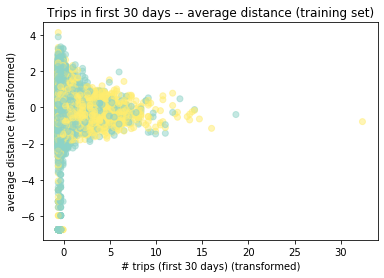

In [32]:
plt.scatter(X_train.trips_in_first_30_days, X_train.avg_dist, c=y_train, alpha=0.5, cmap="Set3")
plt.xlabel("# trips (first 30 days) (transformed)")
plt.ylabel("average distance (transformed)")
plt.title("Trips in first 30 days -- average distance (training set)")

One of the concerns regarding using a logistic regression model is that active/non-active users' data points cannot be separated linearly. The above scatter plot of ```trips_in_first_30_days``` and ```avg_dist``` shows although distributions of the two populations have significant overlaps, it is possible to linearly separate the data points to a large extent. However, if the data were not linearly separable, a decision tree might be a better model.

Text(0, 0.5, 'accuracy')

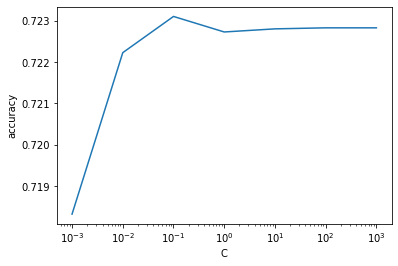

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(penalty="l2", solver="liblinear")
C_grid = {"C" : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_searcher = GridSearchCV(lr, C_grid, cv=20)
grid_searcher.fit(X_train, y_train)

scores = grid_searcher.cv_results_["mean_test_score"]
Cs = grid_searcher.cv_results_["param_C"].data
plt.plot(Cs, scores)
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("accuracy")

The regression uses L2 regularization. Cross-validation within the training set is used to determine the strength of regularization.

accuracy = 0.7249


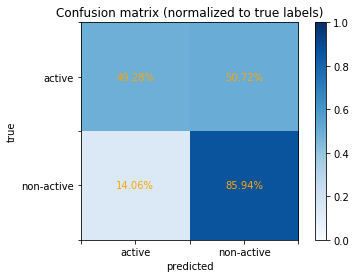

In [34]:
from sklearn.metrics import confusion_matrix
import itertools

best_C = 0.1
classifier = LogisticRegression(penalty="l2", C=best_C, solver="liblinear").fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=[True, False])
cm = cm / np.reshape(np.repeat(np.sum(cm, axis=1), 2), [2, 2])

plt.imshow(cm, cmap="Blues")
for i in range(2) :
    for j in range(2):
        text = plt.gca().text(j, i, str(round(cm[i, j] * 10000) / 100) + str("%"),
                       ha="center", va="center", color="orange")
plt.colorbar()
plt.clim(0, 1)
plt.xlabel("predicted")
plt.xticks(ticks=[-0.5, 0, 0.5, 1, 1.5], labels=["", "active", "", "non-active", ""])
plt.ylabel("true")
plt.yticks(ticks=[-0.5, 0, 0.5, 1, 1.5], labels=["", "active", "", "non-active", ""])
plt.title("Confusion matrix (normalized to true labels)")

print("accuracy = " + str(sum(y_pred == y_test) / len(y_test)))

The accuracy of the classifier is 72%. In true active users, it almost classifies by chance. It does a better job finding true non-active users. Out of all non-active users, the classifier is able to identify 86% of all non-active users.

accuracy = 0.7249


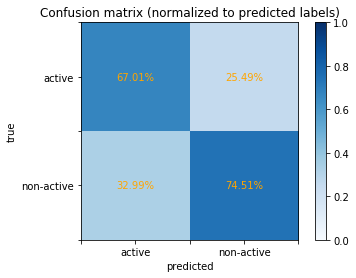

In [35]:
cm = confusion_matrix(y_test, y_pred, labels=[True, False])
cm = cm / np.transpose(np.reshape(np.repeat(np.sum(cm, axis=0), 2), [2, 2]))

plt.imshow(cm, cmap="Blues")
for i in range(2) :
    for j in range(2):
        text = plt.gca().text(j, i, str(round(cm[i, j] * 10000) / 100) + str("%"),
                       ha="center", va="center", color="orange")
plt.colorbar()
plt.clim(0, 1)
plt.xlabel("predicted")
plt.xticks(ticks=[-0.5, 0, 0.5, 1, 1.5], labels=["", "active", "", "non-active", ""])
plt.ylabel("true")
plt.yticks(ticks=[-0.5, 0, 0.5, 1, 1.5], labels=["", "active", "", "non-active", ""])
plt.title("Confusion matrix (normalized to predicted labels)")

print("accuracy = " + str(sum(y_pred == y_test) / len(y_test)))

On average, the classifer performs slightly better in identifying non-active users than confirming active users. Thus, Ultimate could use the model to target non-active users, and launch marketing strategies and promotions to retain them.

precision-recall AUC = 0.6636611101338858


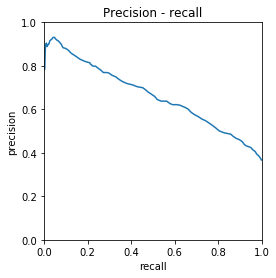

In [36]:
from sklearn.metrics import auc

y_prob = classifier.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0, 1, 101)
true_pos = thresholds * 0
false_pos = thresholds * 0
false_neg = thresholds * 0
true_neg = thresholds * 0
for i, t in enumerate(thresholds):
    y_pred = y_prob > t
    true_pos[i] = sum(y_pred & y_test)
    true_neg[i] = sum((y_pred == False) & (y_test == False))
    false_pos[i] = sum(y_pred & (y_test == False))
    false_neg[i] = sum((y_pred == False) & y_test)
    
precision = true_pos / (true_pos + false_pos)
recall = true_pos / (true_pos + false_neg)
sensitivity = recall
specificity = true_neg / (true_neg + false_pos)

plt.plot(recall, precision)
plt.xlim([0, 1])
plt.xlabel("recall")
plt.ylim([0, 1])
plt.ylabel("precision")
plt.gca().set_aspect("equal")
plt.title("Precision - recall")

precision[-1] = 0
auc_value = auc(recall, precision)
print("precision-recall AUC = " + str(auc_value))

The area under precision-recall curve is 0.66.

Text(0.5, 1.0, 'Sensitivity - specificity')

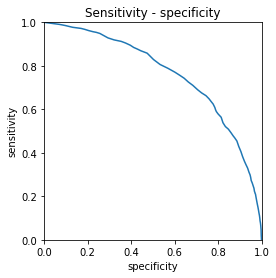

In [37]:
plt.plot(specificity, sensitivity)
plt.xlim([0, 1])
plt.xlabel("specificity")
plt.ylim([0, 1])
plt.ylabel("sensitivity")
plt.gca().set_aspect("equal")
plt.title("Sensitivity - specificity")

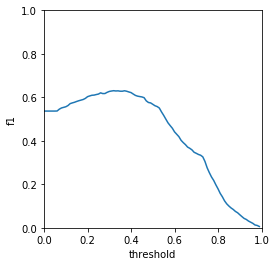

In [38]:
f1 = 2 * precision * recall / (precision + recall)

plt.plot(thresholds, f1)
plt.xlim([0, 1])
plt.xlabel("threshold")
plt.ylim([0, 1])
plt.ylabel("f1")
plt.gca().set_aspect("equal")

Overall, a logstic regression model is able to capture data pattern that predicts user retainablility, especially identifying users who Ultimate might be losing. The company can use similar approaches to find users going inactive, and launch targeted promotion campain to keep them.